In [1]:
import pandas as pd 
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
import warnings


from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image#, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 



#import scipy
#print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


# Set the seed value for experiment reproduci.bility.
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

In [2]:
#define image dataset 
#why do we rescale?
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     


train_dataset = image_generator.flow_from_directory(directory='Multiple_Types_of_Cancer/train',
                                                 target_size=(176,208), 
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(directory='Multiple_Types_of_Cancer/train',
                                                 target_size=(176,208), 
                                                 subset="validation",
                                                 class_mode='categorical')

image_generator_submission = ImageDataGenerator(rescale=1/255) 
submission = image_generator_submission.flow_from_directory(
                                                 directory='AlzheimerDataset/test',
                                                 target_size=(176,208), 
                                                 class_mode=None)

Found 880 images belonging to 4 classes.
Found 219 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


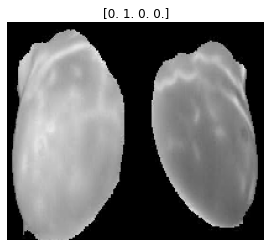

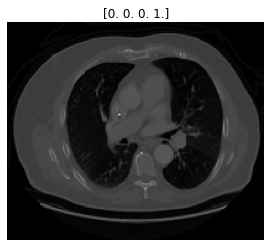

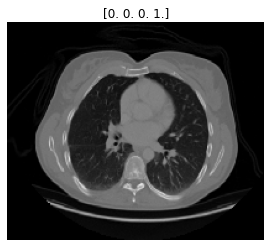

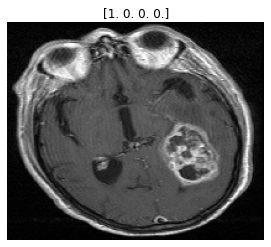

In [3]:
batch_1_img = train_dataset[0]
for i in range(0,4):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.imshow(img)
    plt.title(lab)
    plt.axis('off')
    plt.show()  

# ANN

In [4]:
model = keras.models.Sequential([keras.layers.Flatten(input_shape = [176,208,3]),                             
keras.layers.Dense(300, activation = 'relu' ),

keras.layers.Dense(400, activation = 'relu' ),

keras.layers.Dense(400, activation = 'relu' ),

keras.layers.Dense(400, activation = 'relu' ),
keras.layers.Dense(4, activation = 'softmax')])

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc')])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=True)
model.fit(train_dataset, epochs=1, validation_data=validation_dataset, callbacks=callback)

28/28 [==============================] - 7s 218ms/step - loss: 4.3382 - auc: 0.8710 - val_loss: 0.4611 - val_auc: 0.9752


In [5]:
loss, accuracy = model.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

7/7 [==============================] - 1s 100ms/step - loss: 0.4611 - auc: 0.9752
Loss:  0.46110430359840393
Accuracy:  0.9752264022827148


In [6]:
#simple ann with 3 layers 
model = keras.models.Sequential([keras.layers.Flatten(input_shape = [176,208,3]),                             
keras.layers.Dense(300, activation = 'relu' ),
keras.layers.Dropout(0.2),
keras.layers.Dense(400, activation = 'relu' ),
keras.layers.Dropout(0.2),
keras.layers.Dense(400, activation = 'relu' ),
keras.layers.Dropout(0.2),
keras.layers.Dense(400, activation = 'relu' ),
keras.layers.Dense(4, activation = 'softmax')])
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc')])

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=4,
                                            restore_best_weights=True)

In [7]:
model.fit(train_dataset, epochs=1, validation_data=validation_dataset, callbacks=callback)
#save model
#data manipulation 
#include graphs 

28/28 [==============================] - 7s 215ms/step - loss: 4.8982 - auc: 0.8235 - val_loss: 0.3963 - val_auc: 0.9704


In [8]:
loss, accuracy = model.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

7/7 [==============================] - 1s 102ms/step - loss: 0.3963 - auc: 0.9704
Loss:  0.3963065445423126
Accuracy:  0.9703787565231323


# CNN

In [9]:
#experiment with Convolutional neural net
model = keras.models.Sequential([
keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = [176,208,3]),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(32, (2, 2), activation='relu'),
keras.layers.MaxPooling2D(),

keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),

keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.Flatten(),

keras.layers.Dense(512, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.7),

keras.layers.Dense(128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

keras.layers.Dense(64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.3),

keras.layers.Dense(4, activation ='softmax')])

In [10]:
model.compile(
        optimizer='adam',
        loss=tensorflow.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.AUC(name='auc')]
    )

In [11]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = keras.callbacks.ModelCheckpoint("Multiple_Types_of_Cancer_cnn.h5",
                                                    save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

In [12]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=1
)

28/28 [==============================] - 21s 680ms/step - loss: 0.8408 - auc: 0.8972 - val_loss: 5.0772 - val_auc: 0.4073


In [13]:
loss, accuracy = model.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

7/7 [==============================] - 1s 197ms/step - loss: 5.0772 - auc: 0.4073
Loss:  5.077194690704346
Accuracy:  0.407303124666214


In [14]:
# Generate batch and labels

train_images, train_labels = next(train_dataset)

In [15]:
train_labels

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [16]:
# Label Names 
label_names = {0: 'Brain_cance', 1: 'Breast_cance', 2: 'Cervical_cancer', 3: 'Lung_cance' }

In [17]:
train_images.shape

(32, 176, 208, 3)

In [18]:
train_labels.shape

(32, 4)

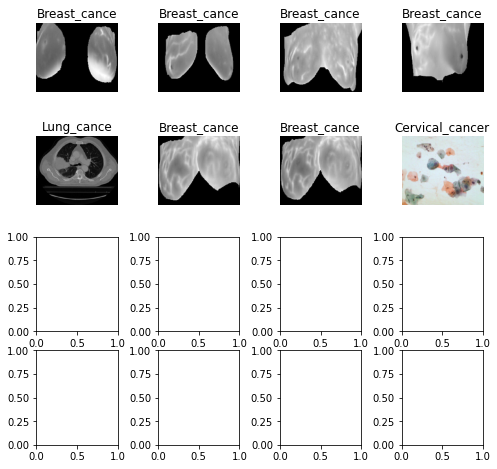

In [19]:
# Data Visualization
Len= 4
Wid=4
fig, axes= plt.subplots(Len, Wid, figsize=(8,8))
axes= axes.ravel()  # Flatten up Y axis

for i in np.arange(0,8):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

# VGG19

In [20]:
vgg = VGG19(input_shape=(176,208,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 208, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 208, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 208, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 104, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 104, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 104, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 52, 128)       0     

In [21]:
modelvgg.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc')])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

In [22]:
modelvgg.fit(train_dataset, epochs=2, validation_data=validation_dataset, callbacks=callback)

Epoch 1/2
28/28 [==============================] - 265s 10s/step - loss: 0.4124 - auc: 0.9749 - val_loss: 0.0235 - val_auc: 1.0000
Epoch 2/2
28/28 [==============================] - 264s 10s/step - loss: 0.0089 - auc: 1.0000 - val_loss: 0.0021 - val_auc: 1.0000


In [23]:
modelvgg.save("Multiple_Types_of_Cancer_vgg19.h5")

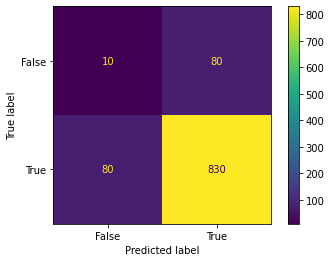

In [24]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [25]:
Precision = metrics.precision_score(actual, predicted)
Sensitivity_recall = metrics.recall_score(actual, predicted)
Specificity = metrics.recall_score(actual, predicted, pos_label=0)
F1_score = metrics.f1_score(actual, predicted)

In [26]:
print({"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"F1_score":F1_score})

{'Precision': 0.9120879120879121, 'Sensitivity_recall': 0.9120879120879121, 'F1_score': 0.9120879120879121}


# 

# 